## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [5]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [6]:
!pip install swifter

In [7]:
!pip install wordcloud

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [8]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
root_path="/content/gdrive/My Drive/complaints-2021-05-14_08_16.json"

Mounted at /content/gdrive


In [9]:
# Opening JSON file
f = open(root_path)  # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
complaints=pd.json_normalize(data)

## Data preparation

In [10]:
# Inspect the dataframe to understand the given data.
complaints.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [11]:
#print the column names
complaints.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [12]:
#Assign new column names
columns=complaints.columns
new_columns=[ column.replace("_source.","") for column in columns ]
complaints.columns = new_columns

In [13]:
#Checking entries where complaint information is blank
len(complaints[complaints['complaint_what_happened']==''])

57241

In [14]:
#Assign nan in place of blanks in the complaints column
complaints[complaints['complaint_what_happened']=='']=np.nan
complaints['complaint_what_happened'].isnull().sum()

57241

In [15]:
#Remove all rows where complaints column is nan
complaints = complaints[~complaints['complaint_what_happened'].isnull()]
complaints['complaint_what_happened'].isnull().sum()

0

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocess(text):
  text = text.lower()
  text = re.sub(r'','',text)
  text = re.sub(r'[^\w\s]', '',text)
  text = re.sub(r'[\d]','',text)
  text = re.sub(r'[*x]?','',text)
  return text

In [17]:
complaints['complaint_what_happened']=complaints['complaint_what_happened'].astype(str)
complaints['complaint_raw']=complaints['complaint_what_happened'].apply(preprocess)

<ipython-input-17-4ab679cd97cd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
#Write your function to Lemmatize the texts
model = spacy.load("en_core_web_sm")
def getLemma(text):
  modified_text =" "
  tokens = model(text)
  for token in tokens :
    if(token.tag_=='NN'):
       modified_text = modified_text + token.lemma_ +" "
  return modified_text[1:]

In [19]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
import swifter
complaints['complaint_lemmatized']=complaints['complaint_raw'].swifter.apply(getLemma)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [20]:
complaint_clean = complaints[['complaint_raw','complaint_lemmatized']]
complaint_clean.head()

,complaint_raw,complaint_lemmatized
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember debt verific...
2,i upgraded my card in and was told by the a...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent credit ident...
11,on while trying to book a ticket i came a...,ticket offer ticket card information offer min...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...


In [21]:
#Write your function to extract the POS tags
def pos_tag(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)


complaint_clean['complaint_POS_removed'] =  complaint_clean['complaint_lemmatized'].apply(lambda x: pos_tag(x))
complaint_clean.head()

<ipython-input-21-5b754851271a>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_raw,complaint_lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...
2,i upgraded my card in and was told by the a...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent credit ident...,card application identity consent credit ident...
11,on while trying to book a ticket i came a...,ticket offer ticket card information offer min...,ticket ticket card information minute screen d...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...


In [22]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
complaint_clean

,complaint_raw,complaint_lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...
2,i upgraded my card in and was told by the a...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent credit ident...,card application identity consent credit ident...
11,on while trying to book a ticket i came a...,ticket offer ticket card information offer min...,ticket ticket card information minute screen d...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...
78309,on wednesday i called chas my visa credit c...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not unders...,pay risk chase bank app chase banking merchant...,risk chase banking merchant merchant communica...
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit chase freedom balance ...,credit chase credit chase freedom balance life...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([9.913e+03, 6.190e+03, 2.513e+03, 1.228e+03, 6.070e+02, 2.380e+02,
        1.180e+02, 7.900e+01, 5.300e+01, 2.400e+01, 2.800e+01, 2.000e+01,
        8.000e+00, 1.100e+01, 7.000e+00, 5.000e+00, 6.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   0.  ,  178.02,  356.04,  534.06,  712.08,  890.1 , 1068.12,
        1246.14, 1424.16, 1602.18, 1780.2 , 1958.22, 2136.24, 2314.26,
        2492.28, 2670.3 , 2848.32, 3026.34, 3204.36, 3382.38, 3560.4 ,
        3738.42, 3916.44, 4094.46, 4272.48, 4450.5 , 4628.52, 4806.54,
        4984.56, 5162.58, 5340.6 , 5518.62, 5696.64, 5874.66, 6052.68,
        6230.7 , 6408

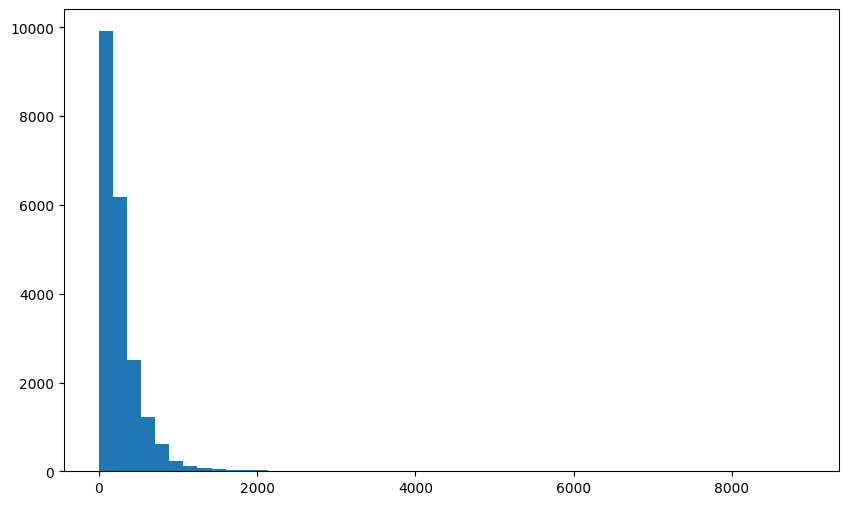

In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in complaint_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)

#### Find the top 40 words by frequency among all the articles after processing the text.

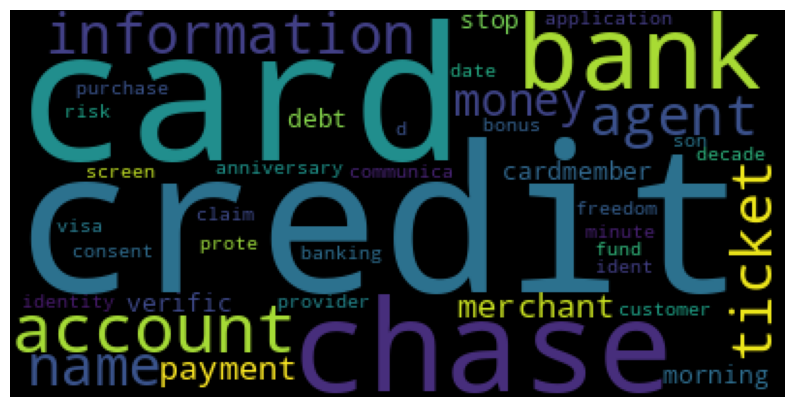

In [24]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
all_sentences =""
for sentence in complaint_clean:
   all_sentences = all_sentences + sentence

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(complaint_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [25]:
#Removing -PRON- from the text corpus
complaint_clean['Complaint_clean'] = complaint_clean['complaint_POS_removed'].str.replace('-PRON-', '')
complaint_clean = complaint_clean.drop(['complaint_POS_removed'],axis = 1)

<ipython-input-25-96e0afc1e984>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
def get_top_n_bigram(text, ngram=1, top=None):
  vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
  bag_of_words = vec.transform(text)

  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:top]

In [27]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_unigrams = get_top_n_bigram(complaint_clean.Complaint_clean,ngram=1, top=30)

In [28]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')
top_30_unigrams[:10]

Top 10 unigrams:



[('chase', 47348),
 ('account', 36040),
 ('credit', 31858),
 ('card', 26539),
 ('payment', 13961),
 ('bank', 13502),
 ('time', 11887),
 ('money', 11458),
 ('loan', 9593),
 ('information', 9142)]

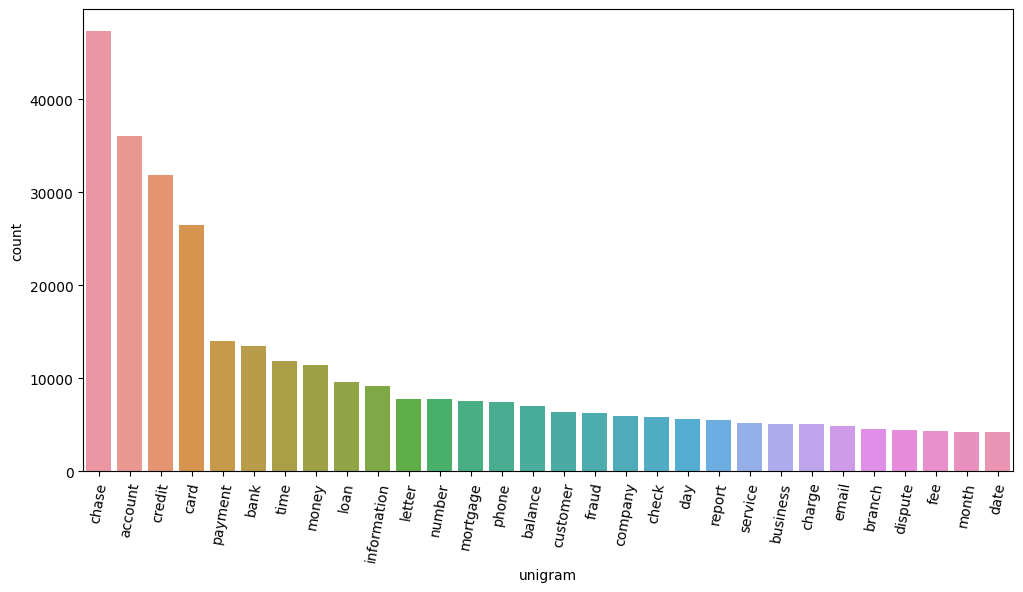

In [29]:
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [30]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_bigrams = get_top_n_bigram(complaint_clean.Complaint_clean,ngram=2, top=30)

In [31]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams:\n')
top_30_bigrams[:10]

Top 10 bigrams:



[('credit card', 11057),
 ('chase credit', 3571),
 ('account account', 3304),
 ('credit report', 3236),
 ('chase account', 3234),
 ('customer service', 2958),
 ('account chase', 2804),
 ('card chase', 1978),
 ('chase chase', 1957),
 ('chase card', 1898)]

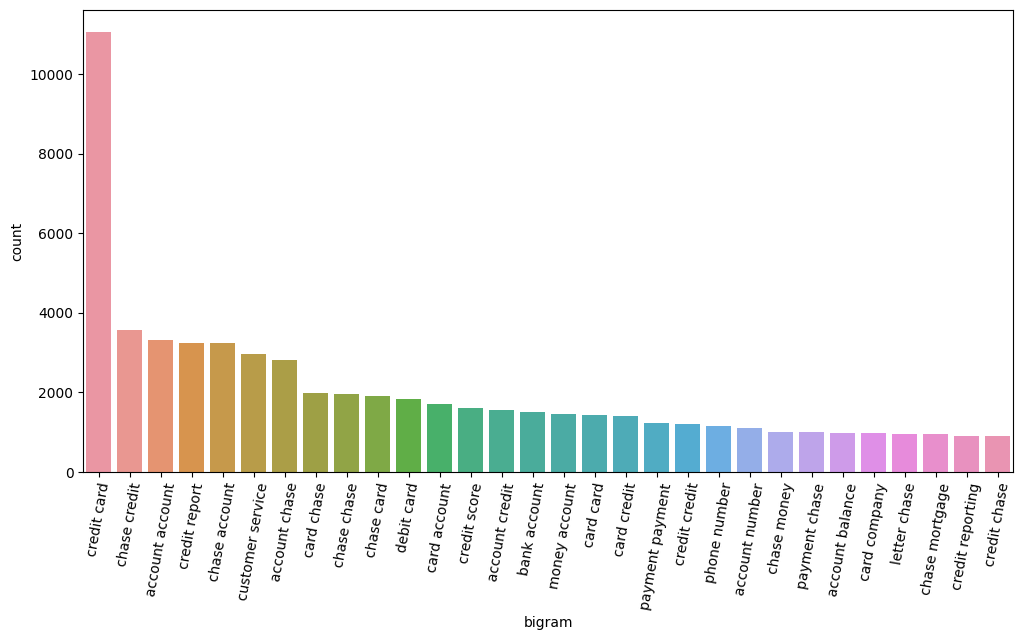

In [32]:
df2 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.xticks(rotation = 80)
plt.show()

In [33]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_trigrams = get_top_n_bigram(complaint_clean.Complaint_clean,ngram=3, top=30)

In [34]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams:\n')
top_30_trigrams[:10]

Top 10 trigrams:



[('chase credit card', 1910),
 ('credit card account', 923),
 ('credit card chase', 874),
 ('credit card company', 826),
 ('credit card credit', 727),
 ('card credit card', 555),
 ('credit report credit', 420),
 ('account chase account', 388),
 ('account credit card', 387),
 ('account account account', 380)]

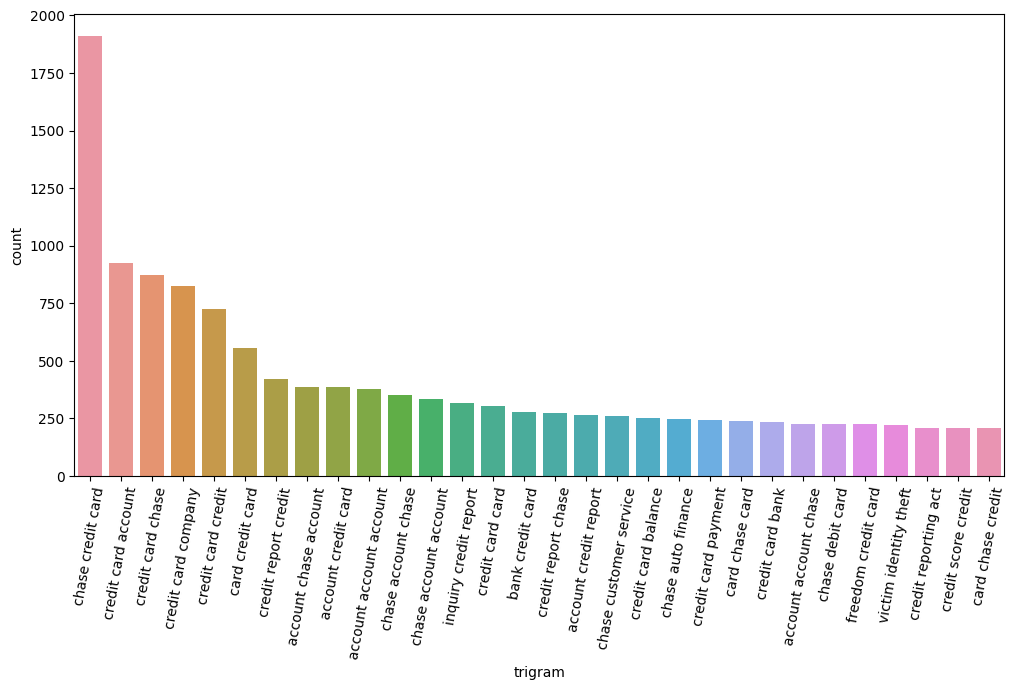

In [35]:
df3 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.xticks(rotation = 80)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [36]:
complaint_clean['Complaint_clean'] = complaint_clean['Complaint_clean'].str.replace('xxxx','')

In [37]:
#All masked texts has been removed
complaint_clean

,complaint_raw,complaint_lemmatized,Complaint_clean
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...
2,i upgraded my card in and was told by the a...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent credit ident...,card application identity consent credit ident...
11,on while trying to book a ticket i came a...,ticket offer ticket card information offer min...,ticket ticket card information minute screen d...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...
78309,on wednesday i called chas my visa credit c...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not unders...,pay risk chase bank app chase banking merchant...,risk chase banking merchant merchant communica...
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit chase freedom balance ...,credit chase credit chase freedom balance life...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [39]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(complaint_clean.Complaint_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [40]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [41]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [42]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

4586

In [43]:
#Print the Top15 words for each of the topics
num_words=15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [44]:
vocab

array(['aarp', 'abandonment', 'abatement', ..., 'zip', 'zombie', 'zone'],
      dtype=object)

In [45]:
topics

['card chase credit charge fraud dispute company merchant fee time purchase debit service customer phone',
 'credit report inquiry score debt information account reporting identity limit company theft history application file',
 'loan mortgage chase home modification property foreclosure time letter rate sale information process income application',
 'account money bank chase check branch deposit number business fraud customer day phone information transaction',
 'payment balance month statement fee date time auto chase bank day error car history plan']

In [46]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(complaint_clean.Complaint_clean))]
complaint_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(complaint_doc_topic.values, axis=1)
complaint_doc_topic['dominant_topic'] = significant_topic
complaint_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.00,0.02,0.01,0.03,0.01,3
Doc1,0.01,0.00,0.00,0.01,0.00,0
Doc2,0.02,0.03,0.00,0.00,0.00,1
Doc3,0.01,0.06,0.01,0.03,0.00,1
Doc4,0.00,0.00,0.00,0.08,0.00,3


In [47]:
#Assign the best topic to each of the cmplaints in Topic Column

complaint_clean['Topic'] = significant_topic #write your code to assign topics to each rows.

In [48]:
complaint_clean.head()

,complaint_raw,complaint_lemmatized,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,3
2,i upgraded my card in and was told by the a...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent...,card application identity consent credit ident...,card application identity consent credit ident...,1
11,on while trying to book a ticket i came a...,ticket offer ticket card information offer min...,ticket ticket card information minute screen d...,1
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,3


In [49]:
#Print the first 5 Complaint for each of the Topics
top5 =complaint_clean.groupby('Topic').head(10)
top5.sort_values('Topic')

,complaint_raw,complaint_lemmatized,Complaint_clean,Topic
59,i currently have over chase ultimate rewards ...,chase chase bonus freedom page request time im...,bonus freedom page request time image error ch...,0
65,i opened the chase rewards credit card at the...,chase credit card time offer reward companion ...,chase credit card time companion link credit c...,0
64,chase is marketing credit cards to those of us...,chase marketing credit credit style marketing ...,chase marketing credit credit style marketing ...,0
63,i tried to send almost at and the transactio...,transaction i service refund card account,transaction refund card account,0
52,my roommate was stealing my chase debit card a...,roommate chase debit card license money accoun...,roommate chase debit card license money pin ph...,0
50,i am a senior citizen that has been scammed by...,citizen time share nothing refund credit card ...,citizen time share nothing credit card informa...,0
48,jp morgan chase bank please answer the followi...,information reason information chase checking ...,information reason information chase account n...,0
40,a sofa love seat table and chairs and was ne...,sofa love seat table debit card bank visa clai...,love seat table debit card bank visa furniture...,0
32,my chase amazon card was declined for a cateri...,chase card catering order funeral amount chase...,chase card catering order funeral amount chase...,0
2,i upgraded my card in and was told by the a...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0


In [50]:
complaint_clean

,complaint_raw,complaint_lemmatized,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,3
2,i upgraded my card in and was told by the a...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent...,card application identity consent credit ident...,card application identity consent credit ident...,1
11,on while trying to book a ticket i came a...,ticket offer ticket card information offer min...,ticket ticket card information minute screen d...,1
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,3
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...,0
78309,on wednesday i called chas my visa credit c...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,0
78310,i am not familiar with pay and did not unders...,pay risk chase bank app chase banking merchant...,risk chase banking merchant merchant communica...,3
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit chase freedom balance ...,credit chase credit chase freedom balance life...,4


In [51]:
complaint_clean[['complaint_raw','complaint_lemmatized','Complaint_clean','Topic']][complaint_clean.Topic==4].head(10)

,complaint_raw,complaint_lemmatized,Complaint_clean,Topic
20,during the summer months i eperience a decline...,summer decline income employment month payment...,summer income employment month payment etensio...,4
58,i made a purchase of on i made payments of ...,purchase payment closing date statement statem...,purchase payment closing date statement statem...,4
82,i recently called to ask chase bank why they r...,bank credit bureau payment info bill balance b...,bureau payment info bill balance bill amount d...,4
141,action taken by the company between the dates ...,action company individual group chase claim in...,action company group chase group payment loan ...,4
167,a double payment from my chase debt cart to ch...,payment chase debt cart credit card request mo...,payment chase debt cart credit card request mo...,4
267,i received an offer from chase visa promising...,offer chase visa companion airline bonus chase...,chase visa visa card card email address phone ...,4
287,i have a chase sapphire reserved card and the ...,sapphire card payment month bill credit card w...,sapphire card payment month bill credit card w...,4
294,spoke to the with payment arrangement at th...,payment arrangement day today payment arrangem...,payment arrangement day today payment arrangem...,4
296,claim number this complaint is in regard to a...,claim number complaint regard charge account p...,claim number complaint regard charge account p...,4
317,ive been actively trying to resolve this conce...,concern bank time credit report fault represen...,concern bank time credit report system chase m...,4


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [52]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
complaint_clean['Topic'] = complaint_clean['Topic'].map(Topic_names)

In [53]:
complaint_clean

,complaint_raw,complaint_lemmatized,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,Theft/Dispute Reporting
2,i upgraded my card in and was told by the a...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Bank Account services
10,chase card was reported on however fraudulent...,card application identity consent credit ident...,card application identity consent credit ident...,Credit card or prepaid card
11,on while trying to book a ticket i came a...,ticket offer ticket card information offer min...,ticket ticket card information minute screen d...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,Theft/Dispute Reporting
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...,Bank Account services
78309,on wednesday i called chas my visa credit c...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Bank Account services
78310,i am not familiar with pay and did not unders...,pay risk chase bank app chase banking merchant...,risk chase banking merchant merchant communica...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit chase freedom balance ...,credit chase credit chase freedom balance life...,Mortgage/Loan


<Axes: xlabel='Topic', ylabel='count'>

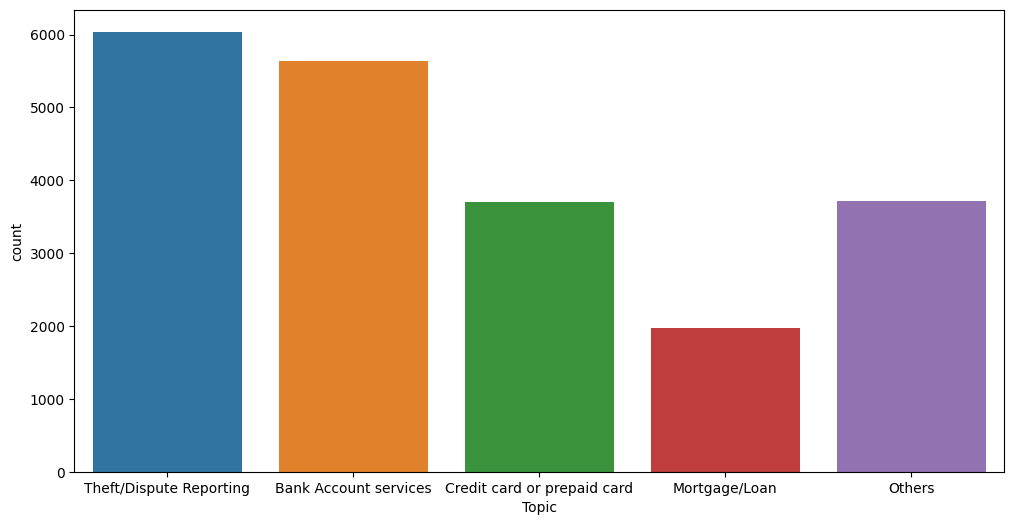

In [54]:
plt.figure(figsize=(12,6))
sns.countplot(x='Topic',data=complaint_clean)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [55]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
#Replace Topics with Topic Names
complaint_clean['Topic'] = complaint_clean['Topic'].map(Topic_names)

In [56]:
complaint_clean

,complaint_raw,complaint_lemmatized,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,3
2,i upgraded my card in and was told by the a...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent...,card application identity consent credit ident...,card application identity consent credit ident...,1
11,on while trying to book a ticket i came a...,ticket offer ticket card information offer min...,ticket ticket card information minute screen d...,1
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,3
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...,0
78309,on wednesday i called chas my visa credit c...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,0
78310,i am not familiar with pay and did not unders...,pay risk chase bank app chase banking merchant...,risk chase banking merchant merchant communica...,3
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit chase freedom balance ...,credit chase credit chase freedom balance life...,4


In [57]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=complaint_clean[['complaint_raw','Topic']]

In [58]:
complaint_clean.head(1)

,complaint_raw,complaint_lemmatized,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,3


In [59]:
training_data

,complaint_raw,Topic
1,good morning my name is and i appreciate it ...,3
2,i upgraded my card in and was told by the a...,0
10,chase card was reported on however fraudulent...,1
11,on while trying to book a ticket i came a...,1
14,my grand son give me check for i deposit it i...,3
...,...,...
78303,after being a chase card customer for well ove...,0
78309,on wednesday i called chas my visa credit c...,0
78310,i am not familiar with pay and did not unders...,3
78311,i have had flawless credit for yrs ive had ch...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [60]:
X = training_data.complaint_raw
y = training_data.Topic

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

from sklearn.feature_extraction.text import TfidfTransformer
#Write your code here to transform the word vector to tf-idf
#Fit transform word vector to TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [61]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [62]:
# Write your code here to build any 3 models and evaluate them using the required metrics





In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [64]:
def display_classification_report(model,metric):

    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')

    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)

    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))

    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)

    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)

    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

In [65]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [66]:
def grid_search(model,folds,params,scoring):

    grid_search = GridSearchCV(model,
                                cv=folds,
                                param_grid=params,
                                scoring=scoring,
                                n_jobs=-1, verbose=1)
    return grid_search

In [67]:
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

#### **Multinomial Naive Bayes Classification**

ROC AUC Score Train: 0.93
ROC AUC Score Test: 0.91
Train Accuracy : 0.68
Test Accuracy : 0.65
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.67      0.79      0.72      4226
           1       0.85      0.44      0.58      2780
           2       0.88      0.71      0.78      2784
           3       0.60      0.94      0.73      4530
           4       1.00      0.01      0.01      1484

    accuracy                           0.68     15804
   macro avg       0.80      0.58      0.57     15804
weighted avg       0.75      0.68      0.65     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68      1409
           1       0.83      0.40      0.54       926
           2       0.88      0.69      0.78       928
           3       0.56      0.91      0.69      1510
           4       0.00      0.00      0.00       495

    accuracy            

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

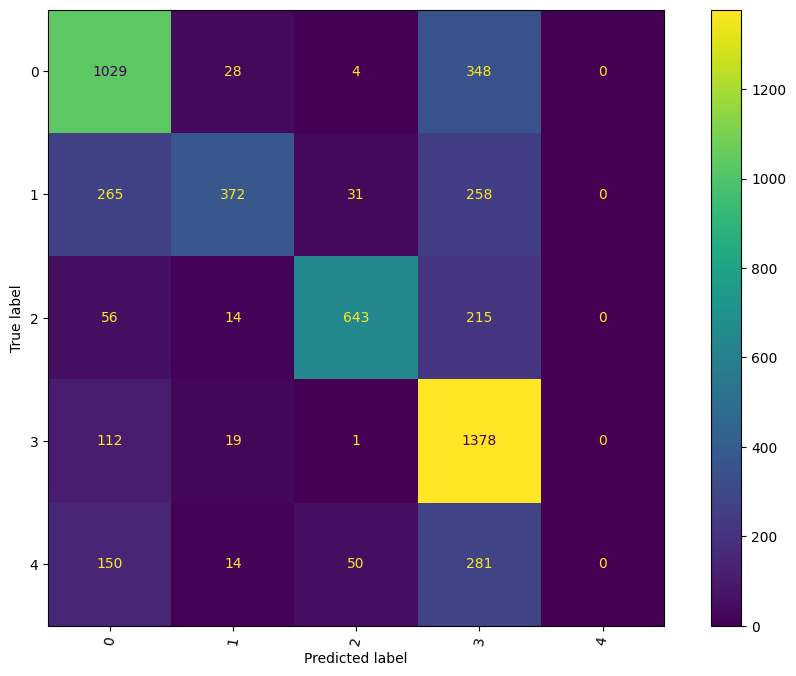

In [68]:
# Multinomial Naive Bayes Classification

# create MNB model object
mnb = MultinomialNB()
# fit model
mnb.fit(X_train, y_train)
# display classification report
metric1=[]
display_classification_report(mnb,metric1)

#### **Logistic Regression Classification**

ROC AUC Score Train: 0.99
ROC AUC Score Test: 0.99
Train Accuracy : 0.93
Test Accuracy : 0.9
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      4226
           1       0.96      0.90      0.93      2780
           2       0.97      0.93      0.95      2784
           3       0.92      0.96      0.94      4530
           4       0.97      0.87      0.92      1484

    accuracy                           0.93     15804
   macro avg       0.94      0.92      0.93     15804
weighted avg       0.94      0.93      0.93     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      1409
           1       0.94      0.86      0.90       926
           2       0.92      0.90      0.91       928
           3       0.88      0.93      0.90      1510
           4       0.95      0.77      0.85       495

    accuracy             

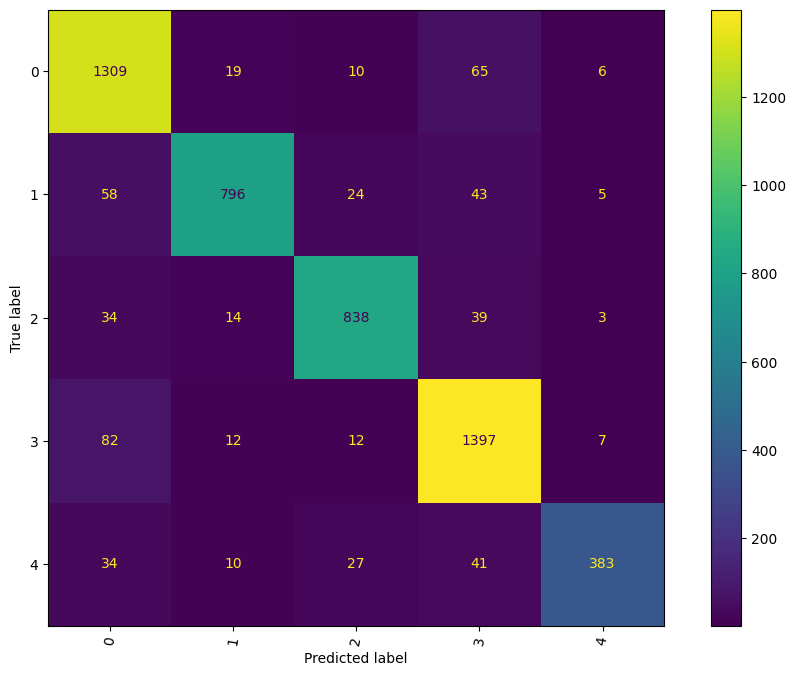

In [69]:
# Logistic Regression Classification
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_report(log_reg,metric2)

#### **Decision Tree Classification**

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.89
Train Accuracy : 1.0
Test Accuracy : 0.82
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4226
           1       1.00      1.00      1.00      2780
           2       1.00      1.00      1.00      2784
           3       1.00      1.00      1.00      4530
           4       1.00      1.00      1.00      1484

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.82      0.83      0.82      1409
           1       0.80      0.79      0.80       926
           2       0.85      0.85      0.85       928
           3       0.84      0.84      0.84      1510
           4       0.81      0.78      0.79       495

    accuracy              

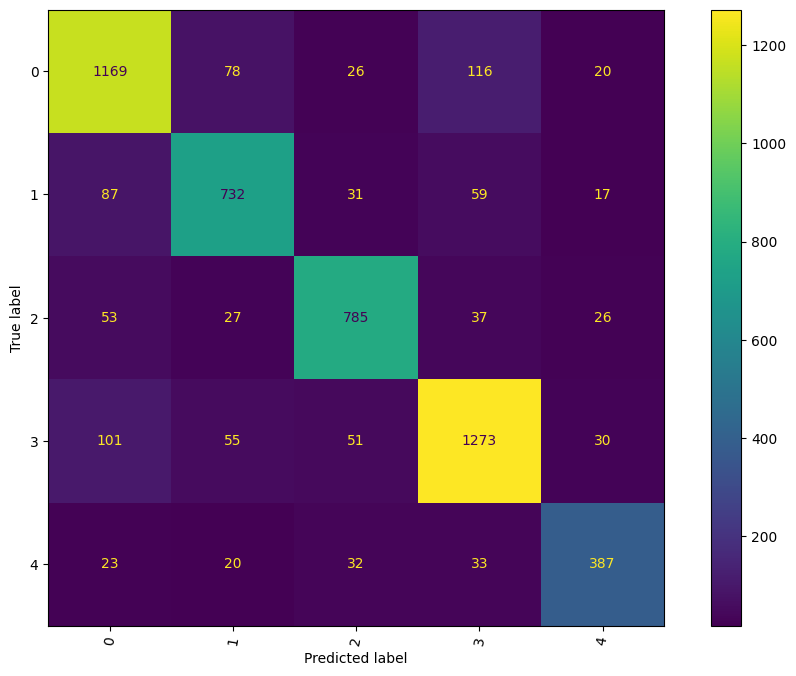

In [70]:
# Decision Tree Classification
dtc = DecisionTreeClassifier(random_state=40)
# fit model
dtc.fit(X_train,y_train)
# Decision Tree Classification Report
metric3=[]
display_classification_report(dtc,metric3)

#### **Random Forest Classification**

OOB SCORE : 0.7953049860794735
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.97
Train Accuracy : 1.0
Test Accuracy : 0.8
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4226
           1       1.00      1.00      1.00      2780
           2       1.00      1.00      1.00      2784
           3       1.00      1.00      1.00      4530
           4       1.00      1.00      1.00      1484

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      1409
           1       0.86      0.71      0.78       926
           2       0.87      0.87      0.87       928
           3       0.77      0.91      0.84      1510
           4       0.96      0.35      0.51       4

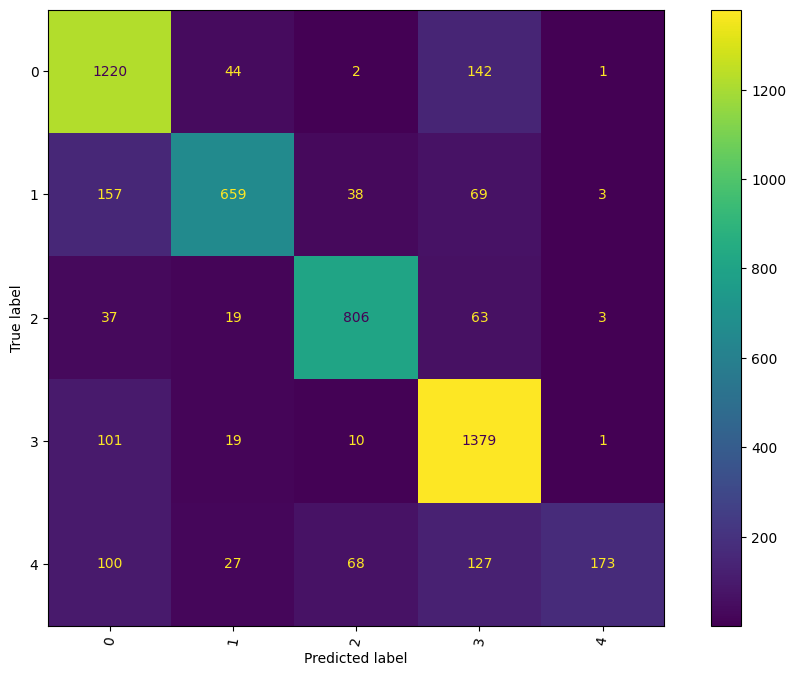

In [71]:
rf = RandomForestClassifier(n_estimators = 500,random_state=40, n_jobs = -1,oob_score=True)
# fit model
rf.fit(X_train,y_train)

# oob score
print('OOB SCORE :',rf.oob_score_)

# Random Forest Classification Report
metric4=[]
display_classification_report(rf,metric4)

#### **Hyper parameter tuning with GridSearchCV**

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.7386740095867754
Best Hyperparameters:  {'alpha': 0.01}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.93
Train Accuracy : 0.87
Test Accuracy : 0.74
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      4226
           1       0.85      0.85      0.85      2780
           2       0.92      0.90      0.91      2784
           3       0.85      0.91      0.88      4530
           4       0.87      0.73      0.79      1484

    accuracy                           0.87     15804
   macro avg       0.87      0.85      0.86     15804
weighted avg       0.87      0.87      0.87     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.74      0.73      0.73      1409
           1       0.72      0.70      0.71       926
           2       0.81      0.84      0.82       928
  

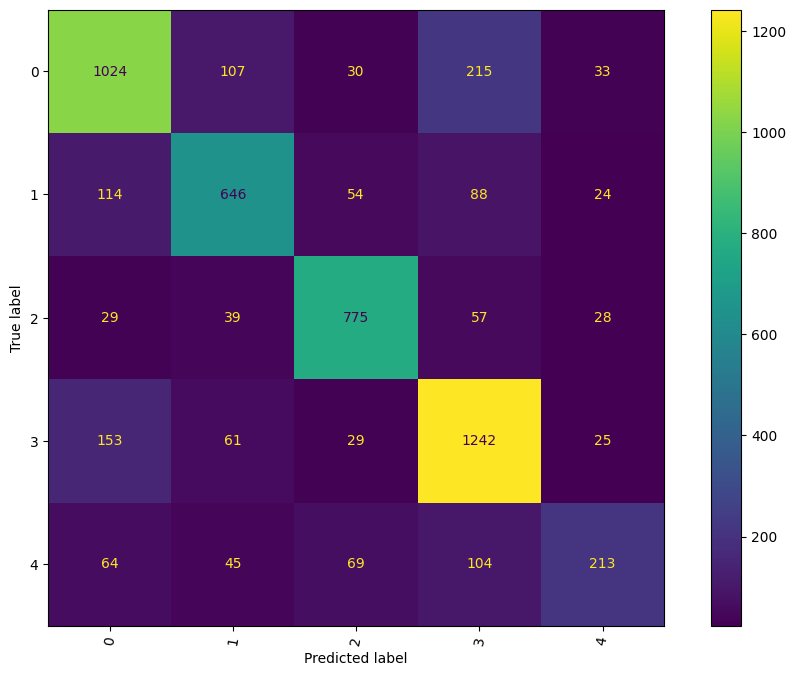

In [72]:
# Multinomial Naive Bayes with GridSearchCV

mnb = MultinomialNB()

mnb_params = {
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)
}

# create gridsearch object
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring=None)

# fit model
grid_search_mnb.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_mnb)

# Random Forest Classification Report
metric5=[]
display_classification_report(grid_search_mnb,metric5)

#### **Logistic Regression with GridSearchCV**

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


15 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

Best Score:  0.9231211081255332
Best Hyperparameters:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
ROC AUC Score Train: 0.99
ROC AUC Score Test: 0.99
Train Accuracy : 0.94
Test Accuracy : 0.93
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93      4226
           1       0.94      0.92      0.93      2780
           2       0.96      0.93      0.95      2784
           3       0.93      0.94      0.94      4530
           4       0.96      0.94      0.95      1484

    accuracy                           0.94     15804
   macro avg       0.94      0.93      0.94     15804
weighted avg       0.94      0.94      0.94     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      1409
           1       0.95      0.91      0.93       926
           2       0.95      0.93      0.94       928
           3       0.92      0.93 

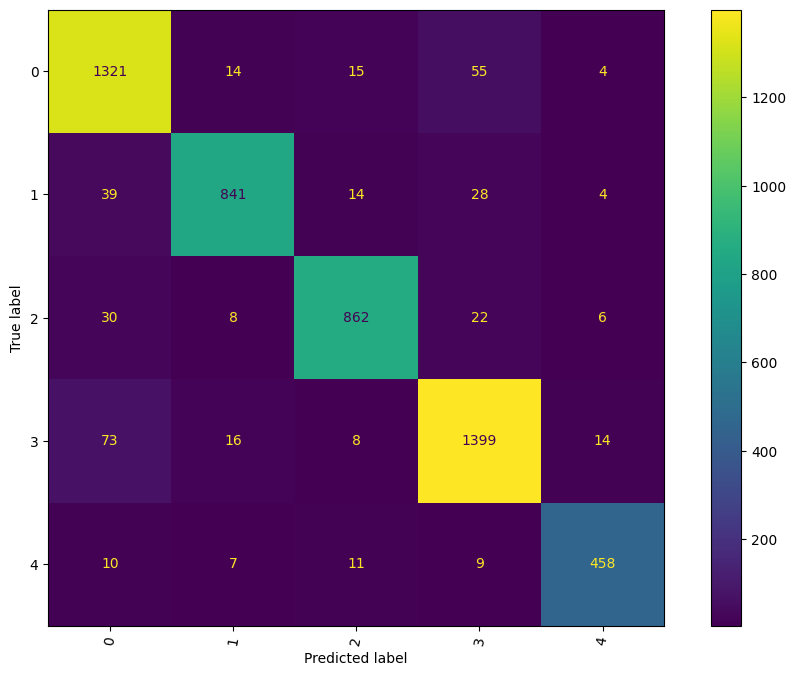

In [73]:
# Logistic Regression with GridSearchCV

# logistic regression
log_reg = LogisticRegression()

# hyperparameter for Logistic Regression
log_params = {'C': [0.01, 1, 10],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

# create gridsearch object
grid_search_log = grid_search(log_reg, folds, log_params, scoring=None)

# fit model
grid_search_log.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_log)

# Random Forest Classification Report
metric6=[]
display_classification_report(grid_search_log,metric6)

#### **Decision Tree Classification with GridSearchCV**

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.9505302636554103
Best Hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 30}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.96
Train Accuracy : 0.85
Test Accuracy : 0.83
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      4226
           1       0.88      0.77      0.82      2780
           2       0.89      0.84      0.86      2784
           3       0.87      0.90      0.88      4530
           4       0.83      0.83      0.83      1484

    accuracy                           0.85     15804
   macro avg       0.86      0.84      0.85     15804
weighted avg       0.86      0.85      0.85     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      1409
           1       0.85      0.74      0.79       926
           2       0.86      

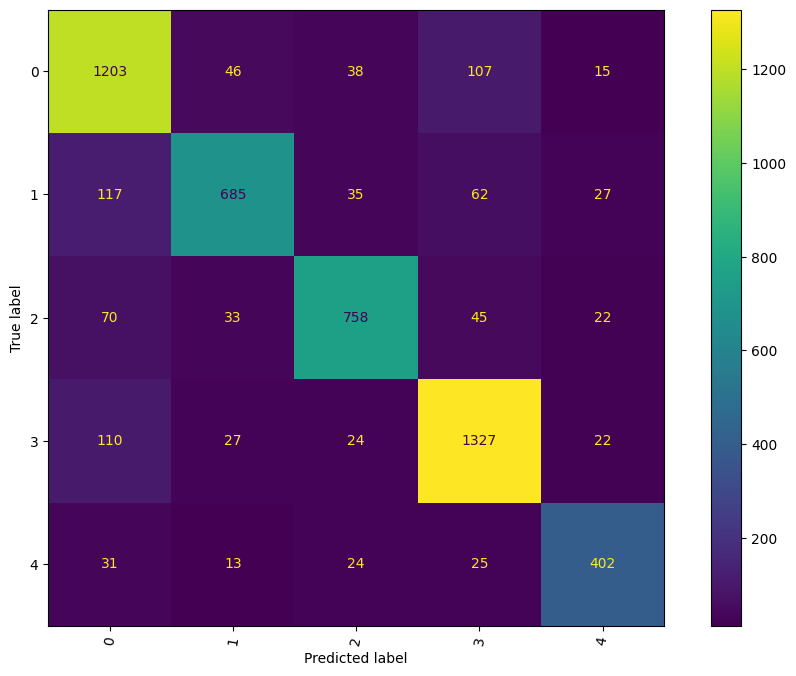

In [74]:
# Decision Tree Classification wuth GridSearchCV

dtc = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'max_depth': [5,10,20,30],
    'min_samples_leaf': [5,10,20,30]
}

# create gridsearch object
grid_search_dtc = grid_search(dtc, folds, dtc_params, scoring='roc_auc_ovr')

# fit model
grid_search_dtc.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_dtc)

# Random Forest Classification Report
metric7=[]
display_classification_report(grid_search_dtc,metric7)

#### **Random Forest Classifier with GridSearchCV**

Fitting 5 folds for each of 18 candidates, totalling 90 fits
OOB SCORE : 0.7456340167046317
Best Score:  0.9568316328540035
Best Hyperparameters:  {'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 200}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.96
Train Accuracy : 0.8
Test Accuracy : 0.75
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.76      0.90      0.82      4226
           1       0.85      0.71      0.78      2780
           2       0.87      0.86      0.86      2784
           3       0.78      0.94      0.85      4530
           4       0.99      0.14      0.24      1484

    accuracy                           0.80     15804
   macro avg       0.85      0.71      0.71     15804
weighted avg       0.82      0.80      0.78     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.70      0.84      0.76      1409
           1       0.81      0.6

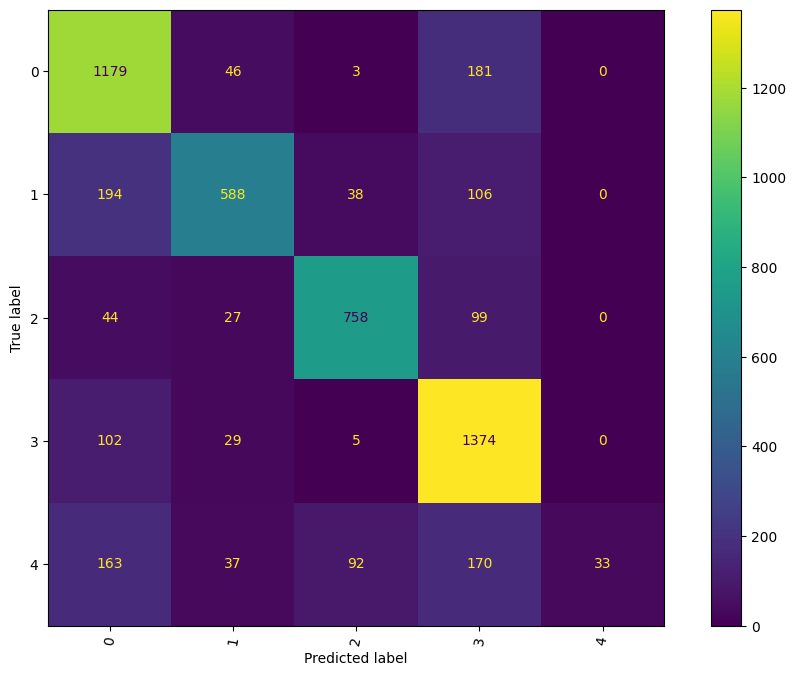

In [76]:
# Random Forest Classifier with GridSearchCV

rfc = RandomForestClassifier(random_state=40, n_jobs = -1,oob_score=True)

# hyperparameters for Random Forest
rfc_params = {'max_depth': [10,20,30],
          'min_samples_leaf': [10,15,20],
          'n_estimators': [100,200]
        }

# create gridsearch object
grid_search_rfc = grid_search(rfc, folds, rfc_params, scoring='roc_auc_ovr')

# fit model
grid_search_rfc.fit(X_train, y_train)

# oob score
print('OOB SCORE :',grid_search_rfc.best_estimator_.oob_score_)

# print best hyperparameters
print_best_score_params(grid_search_rfc)

# Random Forest Classification Report
metric8=[]
display_classification_report(grid_search_rfc,metric8)

### **Model inference**

In [77]:
table = {'Metric': ['ROC_AUC Score(Train)','ROC_AUC Score(Test)',
                    'Accuracy(Train)','Accuracy(Test)',
                    'Precision(Train)','Precision(Test)',
                    'Recall(Train)','Recall(Test)',
                    'F1-Score(Train)','F1-Score(Test)'
                   ],
        'Multinomial Naive Bayes': metric1
        }

mnb_metric = pd.DataFrame(table ,columns = ['Metric', 'Multinomial Naive Bayes'] )
log_metric = pd.Series(metric2, name = 'Logistic Regression')
dtc_metric = pd.Series(metric3, name = 'Decision Tree Classifier')
rfc_metric = pd.Series(metric4, name = 'Random Forest Classifier')
grid_mnb_metric = pd.Series(metric5, name = 'Multinomial Naive Bayes with GridSearchCV')
grid_log_metric = pd.Series(metric6, name = 'Logistic Regression with GridSearchCV')
grid_dtc_metric = pd.Series(metric7, name = 'Decision Tree Classifier with GridSearchCV')
grid_rfc_metric = pd.Series(metric8, name = 'Random Forest Classifier with GridSearchCV')

final_metric = pd.concat([mnb_metric,log_metric,dtc_metric,rfc_metric,
                         grid_mnb_metric,grid_log_metric,grid_dtc_metric,grid_rfc_metric], axis = 1)

final_metric

,Metric,Multinomial Naive Bayes,Logistic Regression,Decision Tree Classifier,Random Forest Classifier,Multinomial Naive Bayes with GridSearchCV,Logistic Regression with GridSearchCV,Decision Tree Classifier with GridSearchCV,Random Forest Classifier with GridSearchCV
0,ROC_AUC Score(Train),0.93,0.99,1.00,1.00,0.98,0.99,0.98,0.98
1,ROC_AUC Score(Test),0.91,0.99,0.89,0.97,0.93,0.99,0.96,0.96
2,Accuracy(Train),0.68,0.93,1.00,1.00,0.87,0.94,0.85,0.80
3,Accuracy(Test),0.65,0.90,0.82,0.80,0.74,0.93,0.83,0.75
4,Precision(Train),0.75,0.94,1.00,1.00,0.87,0.94,0.86,0.82
5,Precision(Test),0.63,0.90,0.82,0.82,0.74,0.93,0.83,0.78
6,Recall(Train),0.68,0.93,1.00,1.00,0.87,0.94,0.85,0.80
7,Recall(Test),0.65,0.90,0.82,0.80,0.74,0.93,0.83,0.75
8,F1-Score(Train),0.65,0.93,1.00,1.00,0.87,0.94,0.85,0.78
9,F1-Score(Test),0.61,0.90,0.82,0.79,0.74,0.93,0.83,0.72


### **Model Inference**

**Complaint Prediction using the best model above**

Logistic Regression with grid search CV appears to have better accuracy than other trained models, so using that model for prediction on custom complaints

In [94]:
# raw complaint text
test_complaint = pd.DataFrame({'complaints':['I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.']})
complaint2={'complaints': 'I can not get from chase who services my mortgage, who owns it and who has original loan docs, \
                                  The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,\
                                  I want to open a salary account at your downtown branch. Please provide me the procedure.,\
                                  Yesterday, I received a fraudulent email regarding renewal of my services.,\
                                  What is the procedure to know my CIBIL score?,\
                                  I need to know the number of bank branches and their locations in the city of Dubai'}
test_complaint = test_complaint.append(complaint2, ignore_index=True)
test_complaint


,complaints
0,I tried to make a transaction at a supermarket...
1,I can not get from chase who services my mortg...


In [95]:
def predict_grid_search_log(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = grid_search_log.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [98]:
test_complaint['predcition']=test_complaint['complaints'].apply(lambda x: predict_grid_search_log([x]))

In [99]:
test_complaint

,complaints,predcition
0,I tried to make a transaction at a supermarket...,Account Services
1,I can not get from chase who services my mortg...,Mortgage/Loan
